# Pairs Trading Backtest

Pairs trading is a nice example of a strategy based on mathematical analysis. 

The principle is as follows:
Let's say you have a pair of securities X and Y that have some underlying economic link. An example might be two companies that manufacture the same product, for example Pepsi and Coca Cola. You expect the spread (ratio or difference in prices) between these two to remain constant with time. However, from time to time, there might be a divergence in the spread between these two pairs. The divergence within a pair can be caused by temporary supply/demand changes, large buy/sell orders for one security, reaction for important news about one of the companies, and so on. When there is a temporary divergence between the two securities, i.e. one stock moves up while the other moves down, the pairs trade would be to short the outperforming stock and to long the underperforming one, betting that the "spread" between the two would eventually converge.

Pairs trading is a market neutral trading strategy enabling traders to profit from virtually any market conditions: uptrend, downtrend, or sideways movement.  It is an example of statistical arbitrage trading.


## Section 1 - Importing libraries and stock prices

### 1.1 Import libraries

In [353]:
%reload_ext autoreload
%autoreload 2

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import PairsTrading as pt

import statsmodels.api as sm
from statsmodels import regression
from statsmodels.tsa.stattools import coint
# set the seed for the random number generator
np.random.seed(107)

## Section 2 - Pair analysis

### 2.1 Stock Initialisation

In [429]:
####### Assign Values to Stock1 and Stock2 ######

Stock1 = 'SHEL.L' #Need to put the market first if comparing against the benchmark
Stock2 = 'IAG.L'

# This indicator specifies whether or not we are using percent change (i.e. returns) if set to 'False' or log prices if set to 'True'
log_use_indicator = False

# Tried MSFT / AAPL and NFLX / AMZN
S1 = yf.download(Stock1,'2013-1-1','2023-4-6', auto_adjust=True)['Close']
S2 = yf.download(Stock2,'2013-1-1','2023-4-6', auto_adjust=True)['Close']

#################################################

#S1 = data[Stock1]
#S2 = data[Stock2]

# Ensure that both Series have the same length by dropping dates that are not in both
# Therefore keeping only trading dates that are in both  as in some cases the two series may have slightly different trading days
# There may be a more clever way to do this but this works
S1.drop(S1[~S1.index.isin(S2.index)].index, inplace=True)
S2.drop(S2[~S2.index.isin(S1.index)].index, inplace=True)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


### 2.2 Visualise the 'naive' ratios

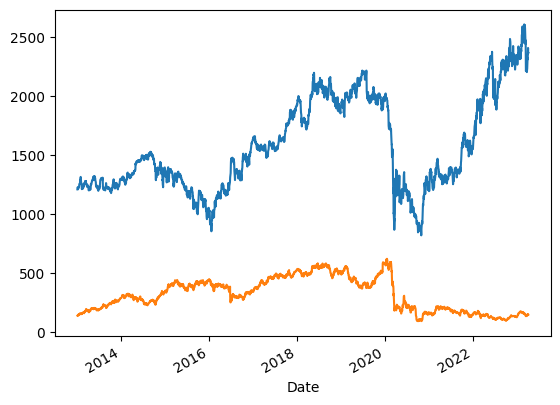

In [430]:
# Plot the share prices (either log or natural)
if log_use_indicator:
    np.log(S1).plot()
    np.log(S2).plot()
else:
    S1.plot()
    S2.plot()


<AxesSubplot: xlabel='Date'>

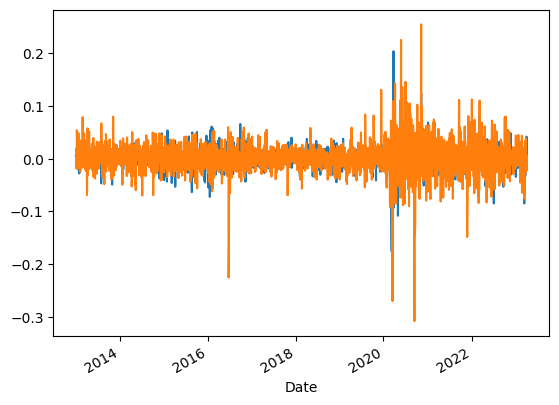

In [431]:
# Plot the returns
# Start at 1 as the first value is nan
ret_S1=S1.pct_change()[1:]
ret_S2=S2.pct_change()[1:]
ret_S1.plot()
ret_S2.plot()

### Cointegration
In this context (pair trading) the concept of cointegration refers to the fact that the spread between two time series will revert to a mean. The concept can be expanded to a number of time series (not just two) and to higher orders of cointegration.  Please look at the Wikipedia article that describes this in more details.

For pairs trading to work between two timeseries, the expected value of the spread over time must converge to the mean, i.e. they should be cointegrated.

The module 'statsmodels.tsa.stattools' contains a cointegration test between two time series.

pvalue = 0.9146017218899483


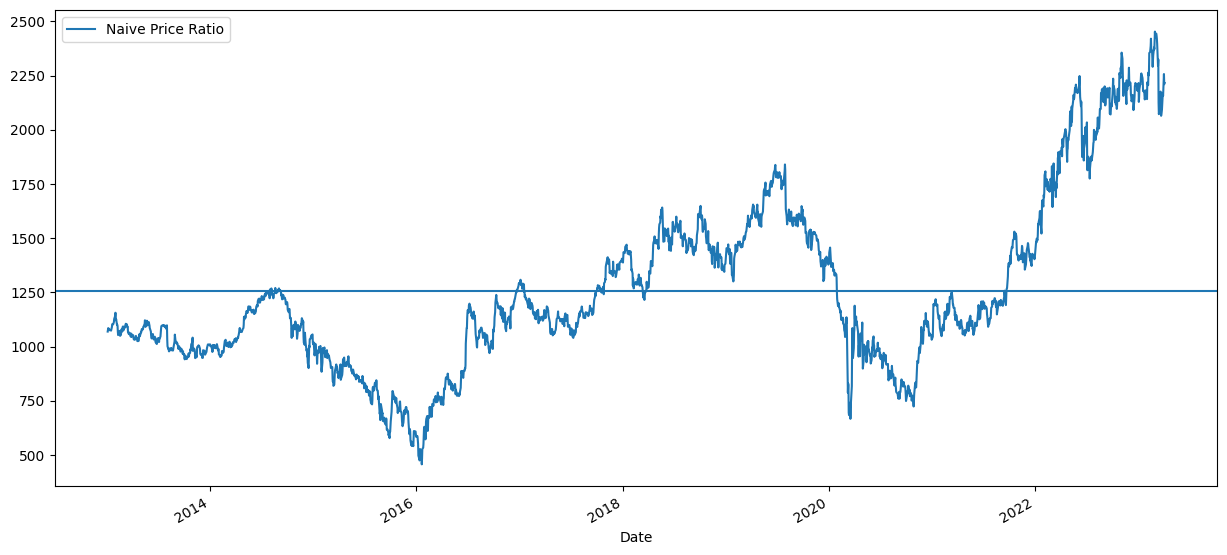

In [432]:
# Test cointegration
score, pvalue, _ = coint(S1, S2)
print(f'pvalue = {pvalue}')
# Typically a pvalue below 5% means the series are cointegrated

# Visualise the naive log ratios (assuming beta = 1, i.e. just the difference of (log) prices)
naive_ratios = pt.ratio(S1, S2, 1, use_log=log_use_indicator)
naive_ratios.plot(figsize=(15,7))
plt.axhline(naive_ratios.mean())
plt.legend(['Naive Price Ratio'])
plt.show()

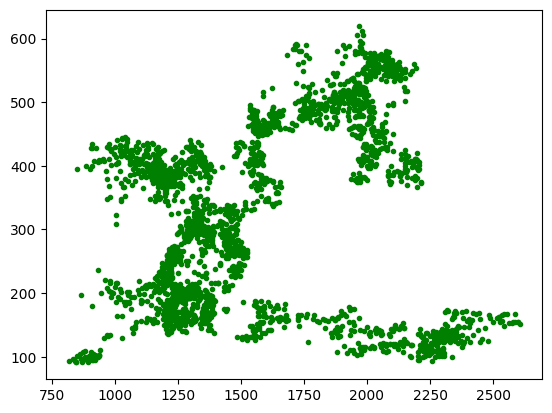

In [433]:
# Visualise the scatter plot of prices (or log prices)
if log_use_indicator:
    plt.plot(np.log(S1), np.log(S2), 'g.')
else:
    plt.plot(S1, S2, 'g.')

### 2.3 Visualise the beta adjusted ratios (residuals of the Total Least Square log regression) and z-score

beta = 3.3083556449937555
alpha = -0.0009630359676173425


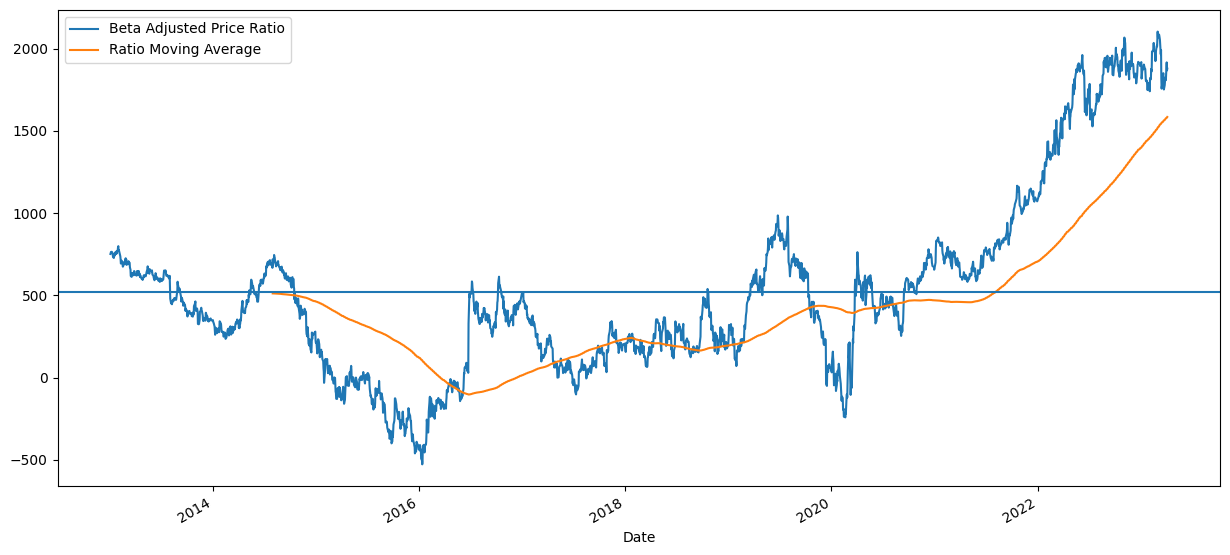

In [434]:
# Find the cointegration coefficient
# This is using the Total Least Square method which we can observe fits better for the values at the extreme
# The correlation is either on the returns (use_log = False) or the log prices (use_log = True)
beta_alpha = pt.find_beta(S1, S2, use_log=log_use_indicator)
beta=beta_alpha[0]
alpha=beta_alpha[1]
print(f'beta = {beta}')
print(f'alpha = {alpha}')

rolling_ratio_window = 400

# Compute the beta adjusted ratios
# Here we compute the spread as S1 - beta*S2 (or log(S1) - beta*log (S2) if using log prices)
beta_ratios = pt.ratio(S1, S2, beta, use_log=log_use_indicator)
ma_ratios = beta_ratios.rolling(rolling_ratio_window).mean()
std_ratios = beta_ratios.rolling(rolling_ratio_window).std()

# Plot
beta_ratios.plot(figsize=(15,7))
ma_ratios.plot()
plt.axhline(beta_ratios.mean())
plt.legend(['Beta Adjusted Price Ratio', 'Ratio Moving Average'])
plt.show()

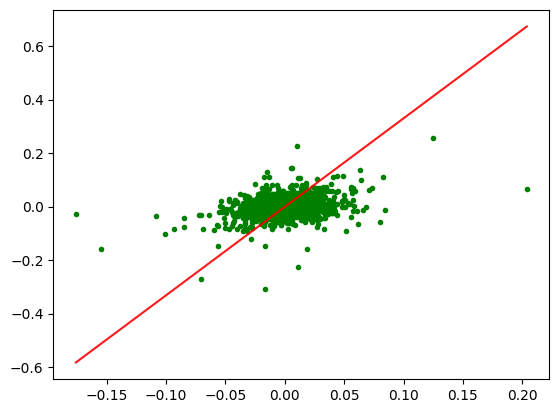

In [435]:
# Visualise the scatter plot of price returns (or log prices depending on the setting)
if not log_use_indicator:
    S1_=ret_S1
    S2_=ret_S2
else:
    S1_=np.log(S1)
    S2_=np.log(S2)

plt.plot(S1_, S2_, 'g.')

# Add the regression line
X2 = np.linspace(S1_.min(), S1_.max(), 100)
Y_hat = X2 * beta + alpha
plt.plot(X2, Y_hat, 'r', alpha=0.9);

In [436]:
# Here we do not use the Total Least Square method but rather an ordinary linear regression 

def linreg(x,y):
    # We add a constant so that we can also fit an intercept (alpha) to the model
    # This just adds a column of 1s to our data
    x_ = sm.add_constant(x)
    model = regression.linear_model.OLS(y,x_).fit()
    return model.params[0], model.params[1]

alpha_, beta_ = linreg(S1_,S2_)
print('alpha: ' + str(alpha_))
print('beta: ' + str(beta_))

alpha: 0.00023237984910162607
beta: 0.49971643863156817


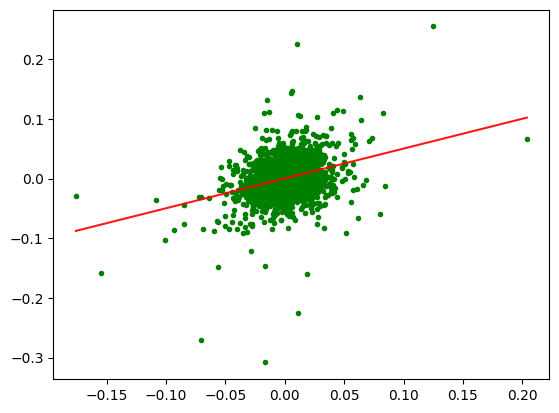

In [437]:
plt.plot(S1_, S2_, 'g.')

# Add the regression line
X2 = np.linspace(S1_.min(), S1_.max(), 100)
Y_hat = X2 * beta_ + alpha_
plt.plot(X2, Y_hat, 'r', alpha=0.9);

The absolute ratio is not very useful in statistical terms. It is more helpful to normalize our signal by treating it as a z-score. Z score is defined as:

<i>Z Score (Value) = (Value — Mean) / Standard Deviation </i>

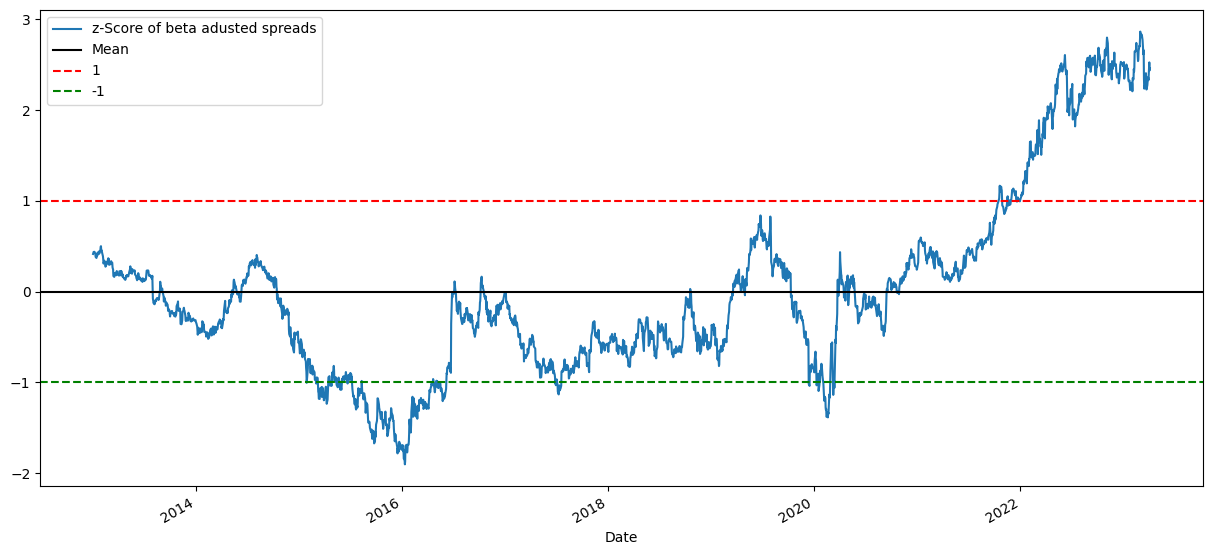

In [438]:
# Visualise the corresponding z-score
zscore = pt.z_score(beta_ratios, beta_ratios.mean(), beta_ratios.std())
zscore.name = 'z-score'

pt.plot_zscore(zscore,1, -1)

### 2.4 Optmise beta

We attempt to find the beta that provides the best reward (profit) by unity of risk (measured by the drawdown).
If one security is vastly outperforming the other the optimal beta may be 0.0 which is not very helpful in pairs trading.
It is therefore important to analyse the graphs to determine the best value for beta that maximises the profit for an acceptable level of drawdown.

stop loss triggered on: 2015-08-24 00:00:00
stop loss triggered on: 2015-12-11 00:00:00
stop loss triggered on: 2016-01-20 00:00:00
stop loss triggered on: 2018-05-11 00:00:00
stop loss triggered on: 2020-03-12 00:00:00
stop loss triggered on: 2020-03-16 00:00:00
stop loss triggered on: 2020-03-18 00:00:00
stop loss triggered on: 2020-10-01 00:00:00
stop loss triggered on: 2022-04-14 00:00:00
stop loss triggered on: 2022-05-23 00:00:00
stop loss triggered on: 2022-11-04 00:00:00
stop loss triggered on: 2015-08-24 00:00:00
stop loss triggered on: 2015-09-28 00:00:00
stop loss triggered on: 2016-01-08 00:00:00
stop loss triggered on: 2018-05-17 00:00:00
stop loss triggered on: 2020-03-12 00:00:00
stop loss triggered on: 2020-03-18 00:00:00
stop loss triggered on: 2020-07-30 00:00:00
stop loss triggered on: 2020-09-30 00:00:00
stop loss triggered on: 2022-04-08 00:00:00
stop loss triggered on: 2022-05-06 00:00:00
stop loss triggered on: 2022-05-23 00:00:00
stop loss triggered on: 2023-02-

<AxesSubplot: >

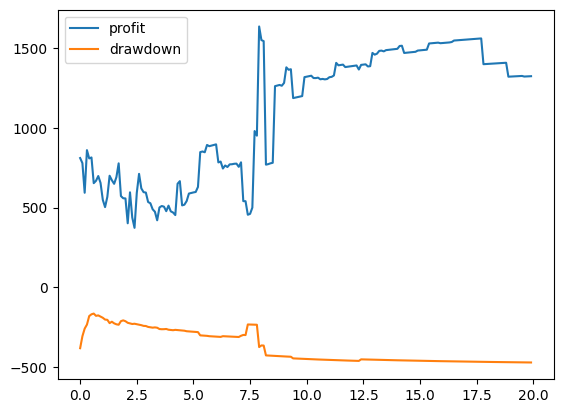

In [439]:
ProfitMap_main = pt.optimise_beta(S1, S2, beta_max=20, stop_loss=0.07, use_log=log_use_indicator)
print('Maximum profit of: ', ProfitMap_main.profit.max(),'for beta of:', float(ProfitMap_main.profit.idxmax()))

ProfitMap_main.plot()

In order to quantify more precisely the reward by unit of risk we use a variant of the Sharpe ratio by comparing the profit to the drawdown.  This is not quite the Sharpe ratio as it is defined ordinarily (excess return / volatility) but our calculation serves a similar purpose. The drawdown in our function is a negative number hence the sign '-' to revert it to a positive number.

<AxesSubplot: >

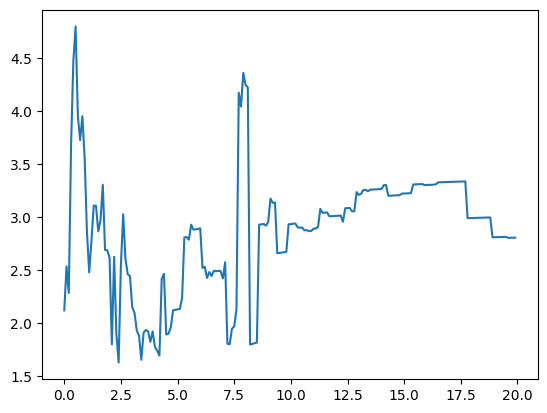

In [440]:
sharpe_ratio = -ProfitMap_main.profit/ProfitMap_main.drawdown
sharpe_ratio.plot()

## Section 3 - Trading the ratios

### 3.1 Preparing train and test data

In [441]:
# Split the data
# Use first 70% of the data for training and last 30% for testing

n_ = len(S1)
n_train = round(0.7 * n_)-1
n_test = n_train + 1

# Allocate prices for training data set
S1Train = S1.iloc[:n_train] # data[Stock1].iloc[:n_train]
S2Train = S2.iloc[:n_train] # data[Stock2].iloc[:n_train]

# Allocate prices for test data set
S1Test = S1.iloc[n_test:] # data[Stock1].iloc[n_test:]
S2Test = S1.iloc[n_test:] # data[Stock2].iloc[n_test:]

# Find the cointegration coefficient for training data using only training data
beta_train = pt.find_beta(S1Train, S2Train, use_log=log_use_indicator)[0]
print(f'beta for training data = {beta_train}')

# Compute the ratios for training data, mean and std using only training data
beta_ratios_train = pt.ratio(S1Train, S2Train, beta_train, use_log=log_use_indicator)
beta_ratios_train_mean = beta_ratios_train.mean()
beta_ratios_train_std = beta_ratios_train.std()


beta for training data = 7.100178034000869


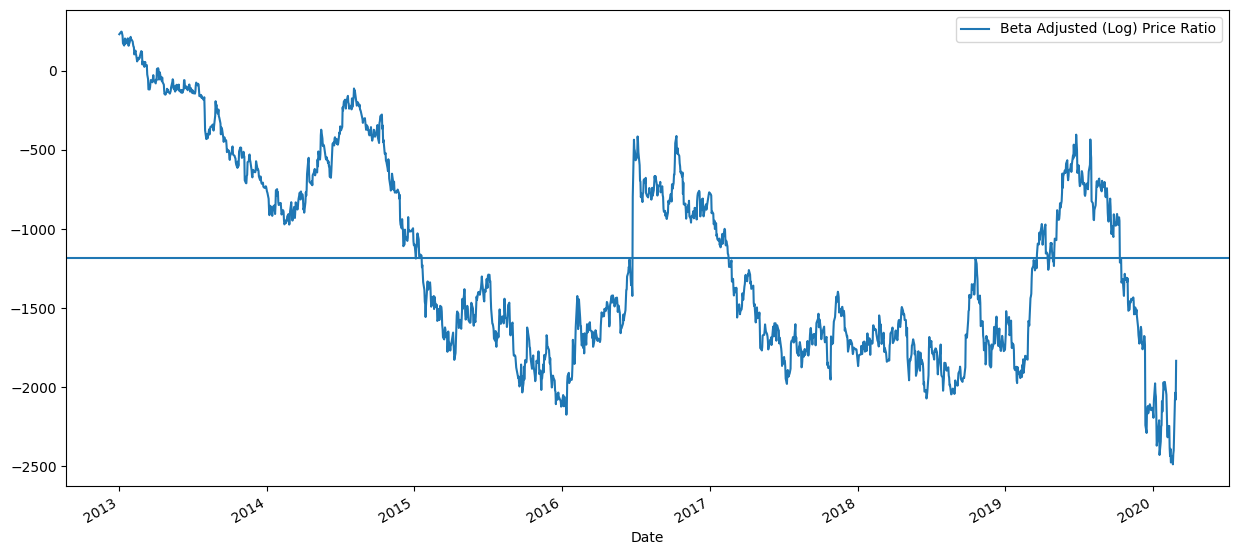

In [442]:
# Visualise the beta adjusted ratios for training data
beta_ratios_train.plot(figsize=(15,7))
plt.axhline(beta_ratios_train_mean)
plt.legend(['Beta Adjusted (Log) Price Ratio'])
plt.show()

### 3.2 Execute the trades on training data

* Go "Long" the ratio whenever the z-score is below -1.0
* Go "Short" the ratio when the z-score is above 1.0
* Exit positions when the z-score approaches zero

The weight of each security is determined by the beta:

weight for long S1 = $\frac{1}{1+\beta}$

weight for short S2 = $\frac{\beta}{1+\beta}$

The trade invests $1,000 spread across the two securities according to the weights above.  Profits are not re-invested and each new trade starts again with $1,000 (actually the currency is determined by the currency of the pair, not necessarily in USD).  The stop loss is triggered as a percentage of the capital invested ($1,000).  Any open trade on the last day of the period is closed.  For simplicity we have not shifted the prices one day between the signal occurring and the trade taking place, which means that there is a little bit of forward looking bias, but these refinments can be added subsequently.

In [443]:
Trade_backtest, pnl_train = pt.tradePair(S1Train, S2Train, 
                            beta=beta_train, 
                            ratio_mean=beta_ratios_train_mean, 
                            ratio_std=beta_ratios_train_std,
                            stop_loss=0.08,
                            use_log=log_use_indicator
                        )


stop loss triggered on: 2014-07-08 00:00:00


### 3.3 Visualise the z-score

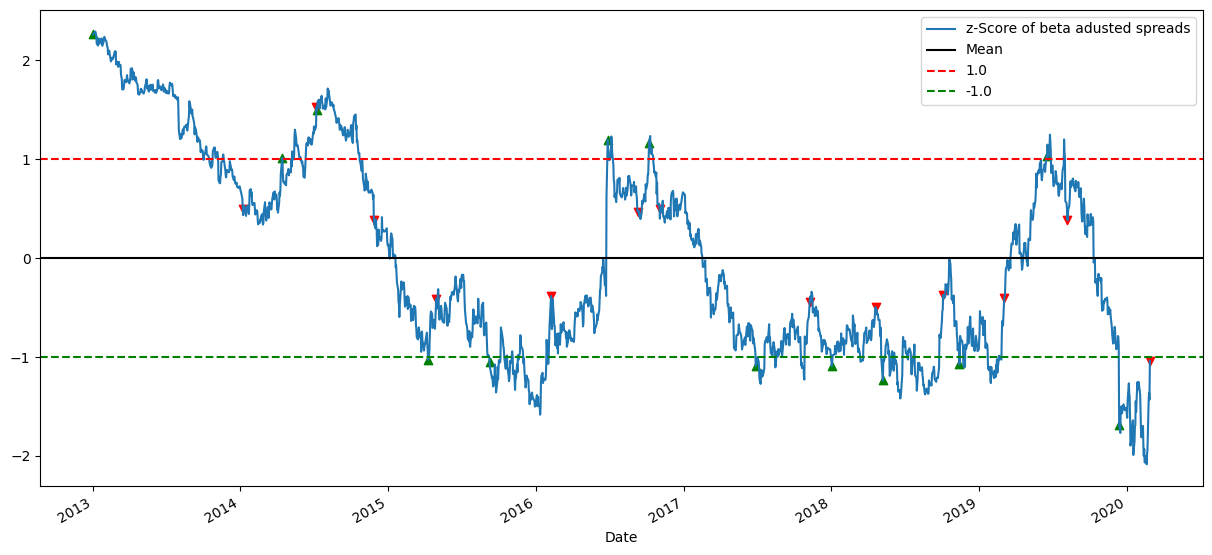

In [444]:
# Compute the z-score for training data
# Of course here there is forward looking bias as we use knowledge of the entire training set to compute z-score
zscore_train = pt.z_score(beta_ratios_train, beta_ratios_train_mean, beta_ratios_train_std)
zscore_train.name = 'z-score-train'

pt.plot_zscore(zscore_train)

plt.scatter(zscore_train.loc[Trade_backtest.dateOpenPosition].index, 
            zscore_train.loc[Trade_backtest.dateOpenPosition].values, 
            marker = '^', color = 'g'
            )
plt.scatter(zscore_train.loc[Trade_backtest.dateClosePosition].index, 
            zscore_train.loc[Trade_backtest.dateClosePosition].values, 
            marker = 'v', color = 'r'
            )

### 3.3 Visualise the daily PnL

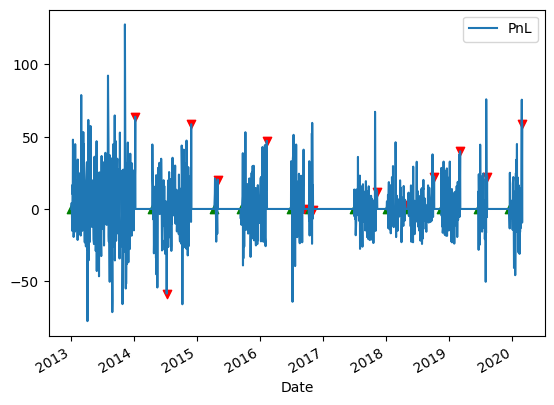

In [445]:
pnl_train.plot()
plt.scatter(pnl_train.loc[Trade_backtest.dateOpenPosition].index, 
            pnl_train.loc[Trade_backtest.dateOpenPosition].values, 
            marker = '^', color = 'g'
            )
plt.scatter(pnl_train.loc[Trade_backtest.dateClosePosition].index, 
            pnl_train.loc[Trade_backtest.dateClosePosition].values, 
            marker = 'v', color = 'r'
            )

### 3.4 Visualise the cumulative PnL

Total Profit = 2460.011370353399


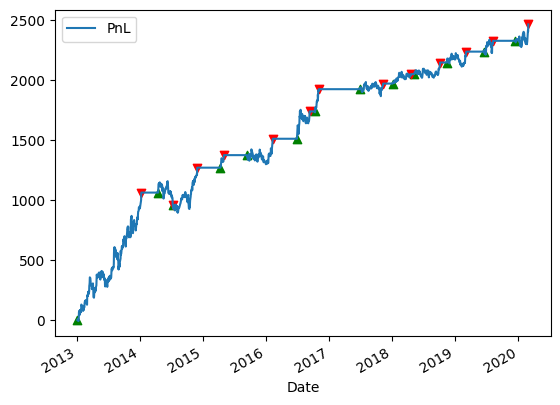

In [446]:
pnl_train_cumsum = pnl_train.cumsum()
print(f'Total Profit = {pnl_train_cumsum.PnL.iloc[-1]}')
pnl_train_cumsum.plot()

plt.scatter(pnl_train_cumsum.loc[Trade_backtest.dateOpenPosition].index, 
            pnl_train_cumsum.loc[Trade_backtest.dateOpenPosition].values, 
            marker = '^', color = 'g'
            )
plt.scatter(pnl_train_cumsum.loc[Trade_backtest.dateClosePosition].index, 
            pnl_train_cumsum.loc[Trade_backtest.dateClosePosition].values, 
            marker = 'v', color = 'r'
            )

In [447]:
print(Trade_backtest)
print(f'Total Profit = {Trade_backtest.profitTrade.sum()}')

    profitTrade dateOpenPosition dateClosePosition
0   1060.282033       2013-01-02        2014-01-07
1   -104.366509       2014-04-15        2014-07-08
2    311.778986       2014-07-09        2014-11-27
3    104.297666       2015-04-10        2015-04-30
4    136.353887       2015-09-09        2016-02-08
5    227.674479       2016-06-27        2016-09-09
6    184.890875       2016-10-07        2016-11-02
7     46.679420       2017-06-28        2017-11-08
8     78.705133       2018-01-02        2018-04-20
9     96.567634       2018-05-08        2018-10-04
10    90.658765       2018-11-13        2019-03-04
11    90.031411       2019-06-17        2019-08-07
12   136.457590       2019-12-13        2020-02-27
Total Profit = 2460.0113703533957


### 3.5a Optimise the stop loss parameter

stop loss triggered on: 2013-01-07 00:00:00
stop loss triggered on: 2014-05-15 00:00:00
stop loss triggered on: 2014-07-08 00:00:00
stop loss triggered on: 2014-07-10 00:00:00
stop loss triggered on: 2014-07-14 00:00:00
stop loss triggered on: 2014-07-17 00:00:00
stop loss triggered on: 2014-07-21 00:00:00
stop loss triggered on: 2014-07-31 00:00:00
stop loss triggered on: 2014-08-04 00:00:00
stop loss triggered on: 2014-08-07 00:00:00
stop loss triggered on: 2015-09-10 00:00:00
stop loss triggered on: 2015-09-14 00:00:00
stop loss triggered on: 2015-09-16 00:00:00
stop loss triggered on: 2015-09-25 00:00:00
stop loss triggered on: 2015-10-19 00:00:00
stop loss triggered on: 2015-10-21 00:00:00
stop loss triggered on: 2015-10-26 00:00:00
stop loss triggered on: 2015-11-11 00:00:00
stop loss triggered on: 2015-12-07 00:00:00
stop loss triggered on: 2015-12-15 00:00:00
stop loss triggered on: 2015-12-17 00:00:00
stop loss triggered on: 2015-12-21 00:00:00
stop loss triggered on: 2015-12-

<AxesSubplot: >

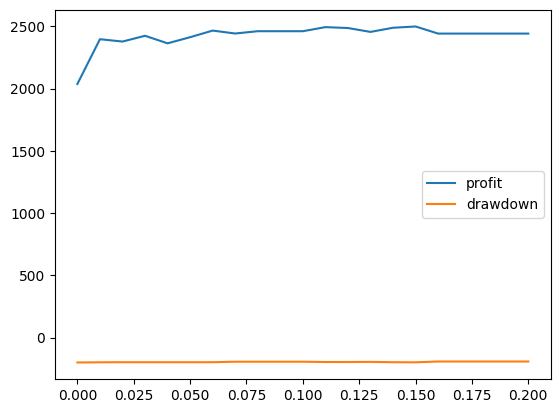

In [448]:
ProfitMap = pt.optmise_stop_loss(S1Train, S2Train, beta_train, beta_ratios_train_mean, beta_ratios_train_std, use_log=log_use_indicator)
print('Maximum profit of: ', ProfitMap.profit.max(),'for Stop Loss of:', float(ProfitMap.profit.idxmax()))

ProfitMap.plot()

### 3.5b Optmise beta

This time we optimise the beta for the training data.

stop loss triggered on: 2015-08-21 00:00:00
stop loss triggered on: 2015-12-14 00:00:00
stop loss triggered on: 2016-01-11 00:00:00
stop loss triggered on: 2018-05-04 00:00:00
stop loss triggered on: 2018-05-17 00:00:00
stop loss triggered on: 2015-08-24 00:00:00
stop loss triggered on: 2015-09-28 00:00:00
stop loss triggered on: 2016-01-08 00:00:00
stop loss triggered on: 2018-05-10 00:00:00
stop loss triggered on: 2015-08-24 00:00:00
stop loss triggered on: 2015-09-28 00:00:00
stop loss triggered on: 2016-01-08 00:00:00
stop loss triggered on: 2018-05-15 00:00:00
stop loss triggered on: 2019-06-24 00:00:00
stop loss triggered on: 2015-08-24 00:00:00
stop loss triggered on: 2015-09-24 00:00:00
stop loss triggered on: 2016-01-08 00:00:00
stop loss triggered on: 2018-05-17 00:00:00
stop loss triggered on: 2019-06-19 00:00:00
stop loss triggered on: 2015-08-24 00:00:00
stop loss triggered on: 2015-09-24 00:00:00
stop loss triggered on: 2016-01-11 00:00:00
stop loss triggered on: 2018-10-

<AxesSubplot: >

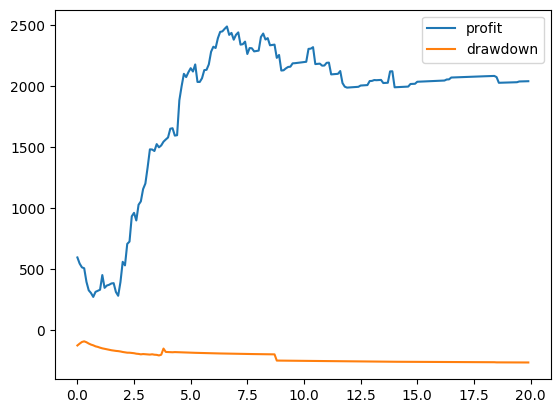

In [449]:
ProfitMap_optBeta = pt.optimise_beta(S1Train, S2Train, beta_max = 20, stop_loss=0.07, use_log=log_use_indicator)
print('Maximum profit of: ', ProfitMap_optBeta.profit.max(),'for beta of:', float(ProfitMap_optBeta.profit.idxmax()))

ProfitMap_optBeta.plot()

### 3.6 Trade on test data

In [450]:
# Use the beta calculated with the training data or the optimised beta on training data
# Use an arbitrary stop loss parameter or the optimised stop loss on training data

stop_loss_test = 0.08
beta_test = beta_train

beta_ratios_train_optBeta_test = pt.ratio(S1Test, S2Test, beta_test, use_log=log_use_indicator)
beta_ratios_train_mean_optBeta_test = beta_ratios_train_optBeta_test.mean()
beta_ratios_train_std_optBeta_test = beta_ratios_train_optBeta_test.std()

Trade_backtest_test, pnl_test = pt.tradePair(S1Test, S2Test, 
                                beta=beta_test, 
                                ratio_mean=beta_ratios_train_mean_optBeta_test, 
                                ratio_std=beta_ratios_train_std_optBeta_test,
                                stop_loss=stop_loss_test,
                                use_log=log_use_indicator
                            )



stop loss triggered on: 2020-03-18 00:00:00
stop loss triggered on: 2022-11-01 00:00:00


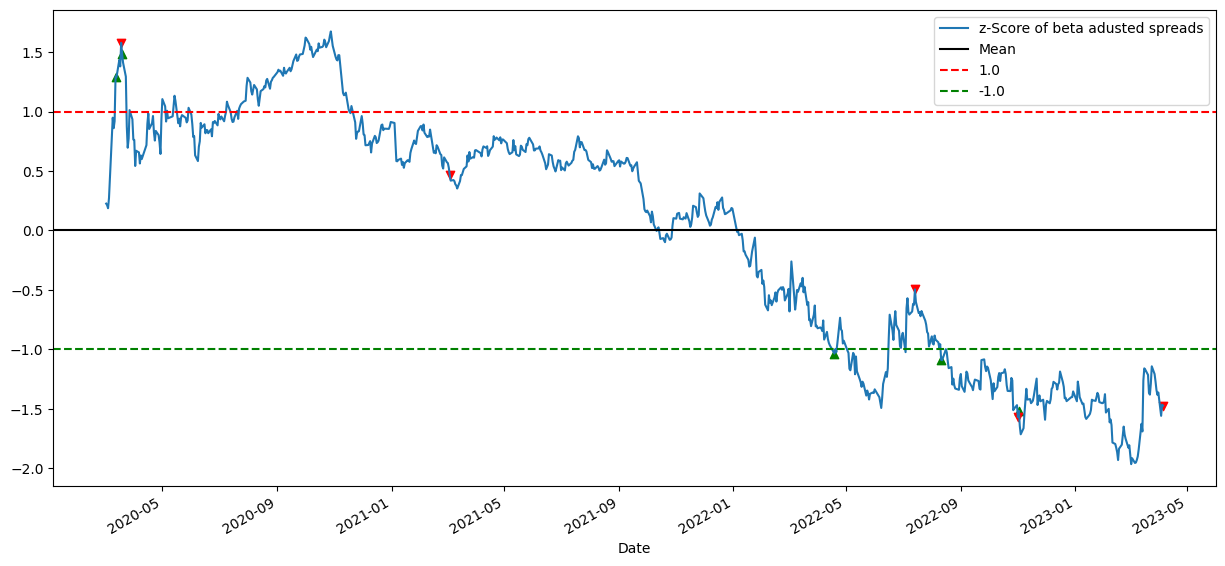

In [451]:
# z-score for test data

# Use beta_train for computing the ratios of test data, avoiding look forward bias
zscore_test = pt.z_score(beta_ratios_train_optBeta_test, beta_ratios_train_mean_optBeta_test, beta_ratios_train_std_optBeta_test)
zscore_test.name = 'z-score-test'

pt.plot_zscore(zscore_test)
plt.scatter(zscore_test.loc[Trade_backtest_test.dateOpenPosition].index, 
            zscore_test.loc[Trade_backtest_test.dateOpenPosition].values, 
            marker = '^', color = 'g'
            )
plt.scatter(zscore_test.loc[Trade_backtest_test.dateClosePosition].index, 
            zscore_test.loc[Trade_backtest_test.dateClosePosition].values, 
            marker = 'v', color = 'r'
            )


In [452]:
# if the mean of the ratios for the training data is lower than the actual mean for the test data (which we can't know in advance)
# Then the computed z-score on test data based on this lower mean will lead to a higher z-score (we don't 'de-mean' enough)
print('ratio mean for test data = ',beta_ratios_train_mean_optBeta_test)
print('ratio mean for train data = ',beta_ratios_train_mean)

ratio mean for test data =  -10002.402663877576
ratio mean for train data =  -1184.0878454262097


   profitTrade dateOpenPosition dateClosePosition
0  -104.376964       2020-03-12        2020-03-18
1   414.887276       2020-03-19        2021-03-04
2    92.992353       2022-04-19        2022-07-14
3   -81.824577       2022-08-11        2022-11-01
4     6.791295       2022-11-02        2023-04-05
Total Profit = 328.4693820642885


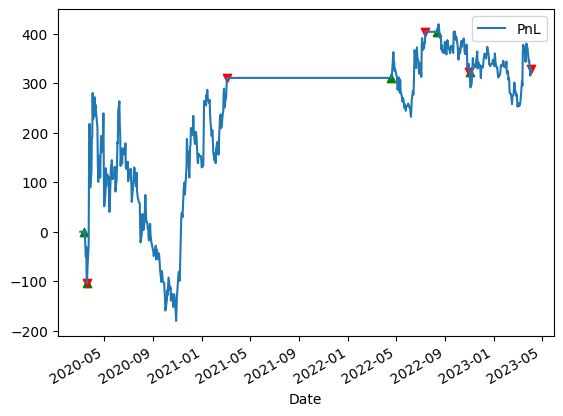

In [453]:
print(Trade_backtest_test)
pnl_test_cumsum = pnl_test.cumsum()
print(f'Total Profit = {pnl_test_cumsum.PnL.iloc[-1]}')
pnl_test_cumsum.plot()
plt.scatter(pnl_test_cumsum.loc[Trade_backtest_test.dateOpenPosition].index, 
            pnl_test_cumsum.loc[Trade_backtest_test.dateOpenPosition].values, 
            marker = '^', color = 'g'
            )
plt.scatter(pnl_test_cumsum.loc[Trade_backtest_test.dateClosePosition].index, 
            pnl_test_cumsum.loc[Trade_backtest_test.dateClosePosition].values, 
            marker = 'v', color = 'r'
            )

The strategy does not yield massive profits but is consistent and controls the risk.  Of course it can also be used to great effect when you have a fundamental reason to believe that one stock is going to outperfom another one by beta hedging the position with the beta calculated as above.  This becomes more of a trend strategy, except that it is the ration that is trending, not the individual stock.  For instance in recent months British Petroleum has outperformed British Airways in part due to rising oil prices benefitting BP and adversely impacting BA.  

The publicly available beta values that can be obtained are generally not of a good quality for this strategy, often based on monthly data over 5 years.  It is instructive to compute your own values and backtest with these.